In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVR

%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj\

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


In [11]:
# import data
mortality = pd.read_csv('mortality_merged.csv')

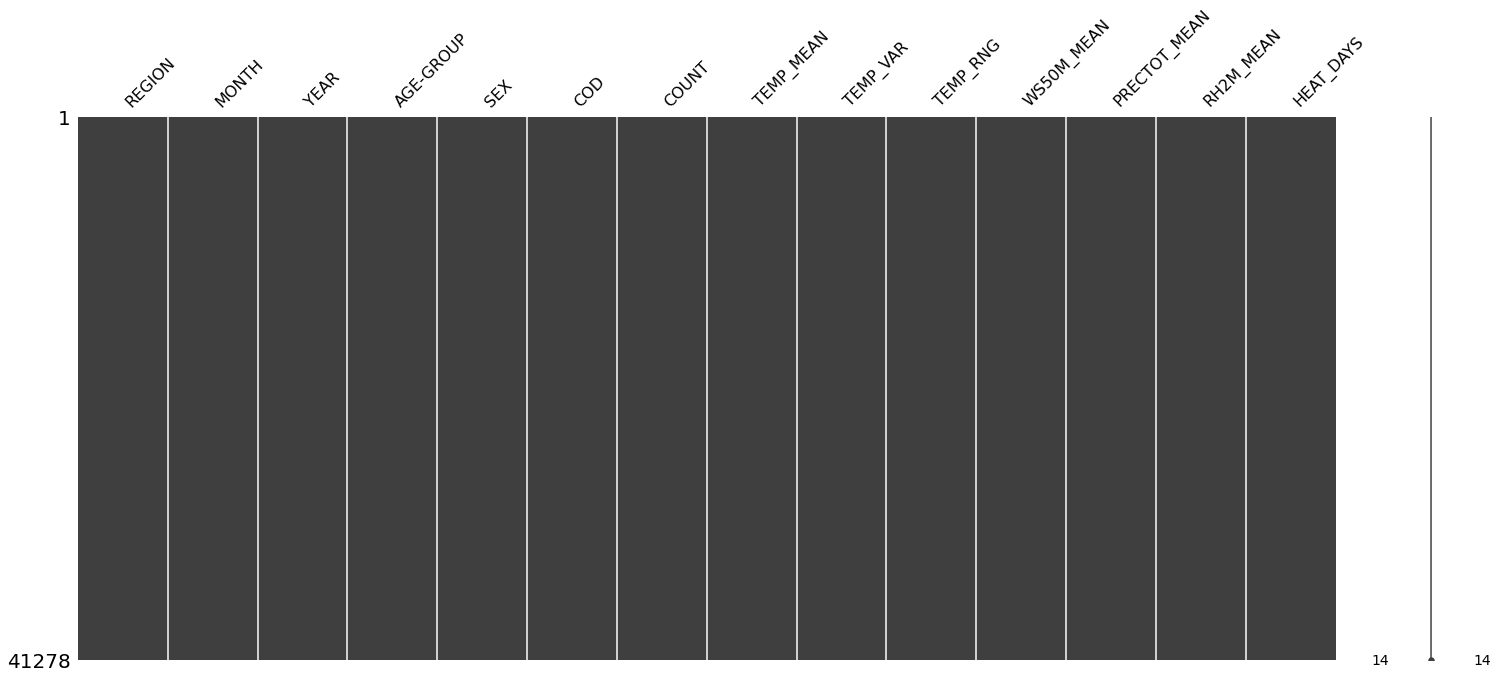

In [12]:
# Check for missing values, it seems alright
missingno.matrix(mortality)

In [13]:
# Summer period, comment it out if you want to do for the whole period
def get_summer(df):
    return df[(df['MONTH'] <= 8) & (df['MONTH'] >= 5)]
mortality = get_summer(mortality)

In [9]:
# Train-test split
TEST_SIZE = 0.1
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop('COUNT', axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [26]:
# Preprocessing steps
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop = 'first')

categorical_features = ['REGION', 'AGE-GROUP', 'SEX', 'COD']
numeric_features = X_train.columns.drop(categorical_features)

preprocessor = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['YEAR', 'MONTH']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [88]:
# Parameter grids
n = np.arange(1, 36)
deg = np.arange(3, 8)
gamma = np.arange(0.005, 0.10, 0.005)
C = np.arange(0.0, 4.0, 0.1)
epsilon = np.arange(0.01, 0.5, 0.05)
params = {'preprocessing__num' : [StandardScaler(), RobustScaler()], 
         'dimension_reduction__n_components': n,
         'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
         'regressor__degree': deg, 
         'regressor__gamma': gamma,
         'regressor__C': C,
         'regressor__epsilon': epsilon}

In [89]:
# Model
model = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('dimension_reduction', PCA()),
    ('regressor', SVR())
])

In [ ]:
# Grid search
search = RandomizedSearchCV(model, 
                            param_distributions = params, 
                            random_state = SEED)
search.fit(X_train, y_train)

In [ ]:
# Summary of grid search
pd.DataFrame(search.cv_results_)

In [ ]:
# Best fitted scores
print(search.best_params_)
print('Best scores: ', search.best_score_)

In [ ]:
# Test performance
model_chosen = search.best_estimator_
y_pred = model_chosen.predict(X_test)

In [ ]:
# Test loss
mean_squared_error(y_pred, y_test)

In [ ]:
# Training loss
mean_squared_error(y_train, model_chosen.predict(X_train))

In [ ]:
sns.regplot(y_test, y_pred, color = 'red')